# Variational Autoencoder

In [1]:
import tensorflow as tf
import numpy as np
import sklearn.preprocessing as prep
import matplotlib.pyplot as plt
%matplotlib inline

## Setting

In [2]:
# Parameters
transfer_function = tf.nn.sigmoid # tf.nn.relu, tf.nn.softplus, tf.nn.sigmoid, tf.nn.tanh
dropout_probability = 0.9
training_epochs = 10
batch_size = 128
display_step = 1

## data set

In [3]:
# Check out https://www.tensorflow.org/get_started/mnist/beginners for
# more information about the mnist dataset

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
X_train, X_test = mnist.train.images, mnist.test.images
n_samples = int(mnist.train.num_examples)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Help functions

In [4]:
def standard_scale(X_train, X_test):
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    return X_train, X_test

In [5]:
def inverse_transform(X_train_original, X_processed):
    preprocessor = prep.StandardScaler().fit(X_train_original)
    X = preprocessor.inverse_transform(X_processed)
    
    return X

In [6]:
def get_random_block_from_data(data, batch_size):
    start_index = np.random.randint(0, len(data) - batch_size)
    
    return data[start_index:(start_index + batch_size)]

## autoencoder model

In [7]:
class VariationalAutoencoder(object):

    def __init__(self, n_input, n_hidden, optimizer = tf.train.AdamOptimizer()):
        self.n_input = n_input
        self.n_hidden = n_hidden

        network_weights = self._initialize_weights()
        self.weights = network_weights

        # model
        self.x = tf.placeholder(tf.float32, [None, self.n_input])
        self.z_mean = tf.add(tf.matmul(self.x, self.weights['w1']), self.weights['b1'])
        self.z_log_sigma_sq = tf.add(tf.matmul(self.x, self.weights['log_sigma_w1']), self.weights['log_sigma_b1'])

        # sample from gaussian distribution
        eps = tf.random_normal(tf.stack([tf.shape(self.x)[0], self.n_hidden]), 0, 1, dtype = tf.float32)
        self.z = tf.add(self.z_mean, tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        self.reconstruction = tf.add(tf.matmul(self.z, self.weights['w2']), self.weights['b2'])

        # cost
        reconstr_loss = 0.5 * tf.reduce_sum(tf.pow(tf.subtract(self.reconstruction, self.x), 2.0))
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq
                                           - tf.square(self.z_mean)
                                           - tf.exp(self.z_log_sigma_sq), 1)
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)
        self.optimizer = optimizer.minimize(self.cost)

        init = tf.global_variables_initializer()
        self.sess = tf.Session()
        self.sess.run(init)

    def _initialize_weights(self):
        all_weights = dict()
        all_weights['w1'] = tf.get_variable("w1", shape=[self.n_input, self.n_hidden],
            initializer=tf.contrib.layers.xavier_initializer())
        all_weights['log_sigma_w1'] = tf.get_variable("log_sigma_w1", shape=[self.n_input, self.n_hidden],
            initializer=tf.contrib.layers.xavier_initializer())
        all_weights['b1'] = tf.Variable(tf.zeros([self.n_hidden], dtype=tf.float32))
        all_weights['log_sigma_b1'] = tf.Variable(tf.zeros([self.n_hidden], dtype=tf.float32))
        all_weights['w2'] = tf.Variable(tf.zeros([self.n_hidden, self.n_input], dtype=tf.float32))
        all_weights['b2'] = tf.Variable(tf.zeros([self.n_input], dtype=tf.float32))
        return all_weights

    def partial_fit(self, X):
        cost, opt = self.sess.run((self.cost, self.optimizer), feed_dict={self.x: X})
        return cost

    def calc_total_cost(self, X):
        return self.sess.run(self.cost, feed_dict = {self.x: X})

    def transform(self, X):
        return self.sess.run(self.z_mean, feed_dict={self.x: X})

    def generate(self, hidden = None):
        if hidden is None:
            hidden = self.sess.run(tf.random_normal([1, self.n_hidden]))
        return self.sess.run(self.reconstruction, feed_dict={self.z: hidden})

    def reconstruct(self, X):
        return self.sess.run(self.reconstruction, feed_dict={self.x: X})

    def getWeights(self):
        return self.sess.run(self.weights['w1'])

    def getBiases(self):
        return self.sess.run(self.weights['b1'])

In [8]:
autoencoder = VariationalAutoencoder(
    n_input=784,
    n_hidden=200,
    optimizer=tf.train.AdamOptimizer(learning_rate = 0.001)
)

In [9]:
for epoch in range(training_epochs):
    avg_cost = 0.
    total_batch = int(n_samples / batch_size)
    # Loop over all batches
    for i in range(total_batch):
        batch_xs = get_random_block_from_data(X_train, batch_size)

        # Fit training using batch data
        cost = autoencoder.partial_fit(batch_xs)
        # Compute average loss
        avg_cost += cost / n_samples * batch_size

    # Display logs per epoch step
    if epoch % display_step == 0:
        print("Epoch:", '%04d' % (epoch + 1), "cost=", "{:.9f}".format(avg_cost))

print("Total cost: " + str(autoencoder.calc_total_cost(X_test)))

Epoch: 0001 cost= 1118.922918750
Epoch: 0002 cost= 661.513600000
Epoch: 0003 cost= 596.484998864
Epoch: 0004 cost= 568.530164205
Epoch: 0005 cost= 554.016872585
Epoch: 0006 cost= 544.957518182
Epoch: 0007 cost= 539.278869531
Epoch: 0008 cost= 529.646027770
Epoch: 0009 cost= 526.541554545
Epoch: 0010 cost= 520.325198580
Total cost: 21916.8


/home/ubuntu/tf_py3.6/lib/python3.6/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


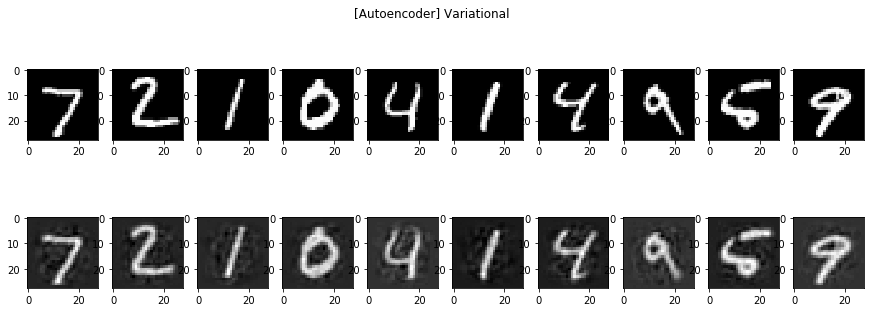

In [10]:
examples_to_show = 10
start_img = 0
idx = range(start_img, start_img + examples_to_show)
X_test_original = mnist.test.images
suptitle_name = '[Autoencoder] Variational'

reconstructed_images = autoencoder.reconstruct(X_test[idx, :])
f, a = plt.subplots(2, examples_to_show, figsize=(15, 5))
for i in range(start_img, examples_to_show):
    a[0][i].imshow(np.reshape(X_test_original[i, :], (28, 28)), cmap=plt.get_cmap('gray'))
    a[1][i].imshow(np.reshape(reconstructed_images[i, :], (28, 28)), cmap=plt.get_cmap('gray'))
plt.suptitle(suptitle_name)
f.show()
# f.savefig('figures/testImage_%s_dropout_%.3f.png' % (func_name, autoencoder.dropout_probability))

In [11]:
autoencoder.weights

{'b1': <tensorflow.python.ops.variables.Variable at 0x7fccdc4fdf60>,
 'b2': <tensorflow.python.ops.variables.Variable at 0x7fcd306021d0>,
 'log_sigma_b1': <tensorflow.python.ops.variables.Variable at 0x7fccdd060be0>,
 'log_sigma_w1': <tensorflow.python.ops.variables.Variable at 0x7fcd30602550>,
 'w1': <tensorflow.python.ops.variables.Variable at 0x7fcd306022e8>,
 'w2': <tensorflow.python.ops.variables.Variable at 0x7fcd30602358>}

In [12]:
encoder_weight = autoencoder.sess.run(autoencoder.weights['w1'])
decoder_weight = autoencoder.sess.run(autoencoder.weights['w2'])

In [13]:
encoder_weight[0, :]

array([  5.07359803e-02,   5.62165231e-02,  -1.43576935e-02,
         6.34561330e-02,   1.12579912e-02,  -5.54081798e-02,
         3.76549363e-02,   6.27537221e-02,  -1.86782256e-02,
        -4.99783866e-02,  -4.64526489e-02,   6.20718747e-02,
         2.21179649e-02,   1.72609985e-02,   1.40234530e-02,
         5.63186407e-02,   2.08057240e-02,   1.85888782e-02,
         2.61238292e-02,   7.40490705e-02,   9.64554399e-03,
         4.41306382e-02,  -1.50120333e-02,  -7.08208233e-02,
         2.58194506e-02,   2.88669765e-03,  -6.94111139e-02,
        -1.57828890e-02,  -7.53555670e-02,  -6.97316676e-02,
        -2.42088288e-02,   2.43998244e-02,   4.82373685e-03,
        -4.82636690e-03,  -2.50868499e-04,   2.80178636e-02,
         3.35216597e-02,   3.34523469e-02,  -5.01367822e-02,
        -6.82412386e-02,   1.11124590e-02,  -5.36425449e-02,
         2.73782462e-02,   6.59479201e-02,   5.38001209e-02,
         6.06232882e-02,   1.91558301e-02,  -8.27191770e-03,
         3.83245870e-02,

In [14]:
decoder_weight[:, 0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [15]:
encoder_bias = autoencoder.sess.run(autoencoder.weights['b1'])
decoder_bias = autoencoder.sess.run(autoencoder.weights['b2'])

In [16]:
encoder_bias

array([-0.00998939, -0.06260014, -0.08334792,  0.01353287,  0.15558794,
        0.09586941,  0.02015993,  0.07642175,  0.05262602,  0.04954446,
       -0.06057109,  0.04100217, -0.0210187 , -0.00796437, -0.12239715,
       -0.19525376, -0.04769494,  0.11336863,  0.06025725,  0.07529359,
       -0.23072813, -0.08417925,  0.02661609,  0.01398514, -0.01539634,
        0.10891674,  0.09447189, -0.08357628, -0.02961618,  0.18347649,
        0.04203832,  0.05311925, -0.0118177 ,  0.0107534 , -0.15514734,
        0.12006979, -0.30381048, -0.24229726,  0.02296663,  0.1335198 ,
       -0.02664598,  0.2825743 ,  0.06233467, -0.07587842,  0.08812484,
        0.09749644, -0.06886372, -0.11804094,  0.01718354, -0.11031996,
       -0.0265316 , -0.02239547, -0.08552064,  0.02625309, -0.18291725,
        0.04523475,  0.02222373,  0.00871503, -0.18009417,  0.05541651,
        0.13027163,  0.01942409, -0.02195348, -0.1300056 , -0.06073447,
       -0.01700786, -0.13981259, -0.00850048,  0.03093549, -0.03

In [17]:
decoder_bias

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -1.08379412e-04,  -1.02910035e-05,   1.58891446e-04,
         7.94007559e-04,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   2.61404726e-04,
        -3.82335129e-04,  -1.47967497e-04,   2.61116948e-04,
         6.15889148e-05,   1.02076076e-04,   7.35796348e-04,
         1.40015455e-03,   2.10709404e-03,   1.10843661e-03,
        -3.56946723e-04,  -7.84242526e-04,   6.40821003e-04,
         9.30142531e-04,   4.51259431e-04,   6.68444263e-04,
         4.38467803e-04,

In [18]:
encoder_bias.shape

(200,)

In [19]:
decoder_bias.shape

(784,)